## Generate time series plot from H(x) IODA files
This notebook will calulate bias and root-mean-square-error from ObsValue and hofx group available in H(x) IODA files.

In [6]:
import os
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from functions import get_dates, set_size
from joblib import Parallel, delayed
from tqdm import tqdm

### Setup the running period, observation folder names, features of figure, etc.

In [7]:
tlsize = 12
txsize = 12
mpl.rc("axes", titlesize=tlsize, labelsize=txsize)
mpl.rc("xtick", labelsize=txsize)
mpl.rc("ytick", labelsize=txsize)
mpl.rc("legend", fontsize="large")
minussign = "\u2212"

axe_w = 8
axe_h = 3
plot_quality = 600
# Colorbar control
cb_ori = "vertical"
cb_frac = 0.025
cb_pad = 0.04
cb_asp = 32
plotqc = -1

srcpath = "/glade/work/swei/Git/JEDI-METplus"

plot_product = "wrfchem_evaluate"
obs_name_list = [
    "tropomi_s5p_no2_troposphere-wxaq",
    "tempo_no2_tropo-wxaq",
]

# JEDI variable name, var:channel
plot_var = "nitrogendioxideColumn"
# units_str = 'mol m$^{-2}$'
units_str = "10$^{15}$ molec cm$^{-2}$"

vrfy_init = "00"
vrfy_day = 1
sdate = 2024082201
edate = 2024090100
hint = 1
dates = get_dates(sdate, edate, hint)

### Setup default variable name, units, paths, and functions

In [8]:
obsname_dict = {
    "tropomi_s5p_no2_troposphere-wxaq": "TROPOMI",
    "tempo_no2_tropo-wxaq": "TEMPO",
}
varstr_dict = {
    "nitrogendioxideColumn": "Tropospheric NO$_{2}$",
    "nitrogendioxideTotal": "Total NO$_{2}$",
    "carbonmonoxideTotal": "Total CO",
}
units_factors_dict = {
    "mol m$^{-2}$": 1.0,
    "10$^{15}$ molec cm$^{-2}$": 6.022e4,
}
ylbstr = "%s (%s)" % (varstr_dict[plot_var], units_str)

hofx_path = os.path.join(srcpath, "output", plot_product, "hofx")
plts_path = os.path.join(srcpath, "output", plot_product, "plots", "timeseries")

if not os.path.exists(hofx_path):
    raise Exception(f"HofX folder: {hofx_path} is not available")

if not os.path.exists(plts_path):
    os.makedirs(plts_path)


def get_fhr(cdate, from_init, day_n_fcst):
    """
    Find the forecast hour based on
    cdate: current cycle, datetime object
    from_init: 2-digit string of 'HH',
        indicates create forecast hour based on which cycle to be initialized from.
    day_n_fcst: integer, the day 'i' forecast to be searched and verified, 1: 1-24 hour forecasts.
    """
    if int(from_init) >= int(cdate.strftime("%H")):
        fhr = (day_n_fcst) * 24 - abs(int(from_init) - int(cdate.strftime("%H")))
    else:
        fhr = (day_n_fcst - 1) * 24 - (int(from_init) - int(cdate.strftime("%H")))
    return f"{fhr:02d}"


def process_dates_bias_rmse(cdate, obsname, varname, vrfy_init, vrfy_day):
    tmpdf = pd.DataFrame()
    tmpdf["obsname"] = [obsname]
    tmpdf["datetime"] = [cdate]

    cdate_str = cdate.strftime("%Y%m%d%H")
    fhr_str = get_fhr(cdate, vrfy_init, vrfy_day)
    hofxfile = f"{hofx_path}/f{fhr_str}/{obsname}/hofx.{obsname}.{cdate_str}.nc4"
    if not os.path.exists(hofxfile):
        tmpdf["bias"] = [np.nan]
        tmpdf["rmse"] = [np.nan]
    else:
        obsvds = xr.open_dataset(hofxfile, group="ObsValue")
        hofxds = xr.open_dataset(hofxfile, group="hofx")
        obsv = obsvds[varname].values * units_factors_dict[units_str]
        hofx = hofxds[varname].values * units_factors_dict[units_str]

        bias = np.nanmean(hofx - obsv)
        rmse = np.sqrt(np.nanmean(np.square(hofx - obsv)))
        tmpdf["bias"] = [bias]
        tmpdf["rmse"] = [rmse]
    return tmpdf

### Create Pandas DataFrame, and convert UTC to local time (EST in this case)

In [9]:
all_df = pd.DataFrame()
for obs in obs_name_list:
    print(f'Processing {obs}')
    results = Parallel(n_jobs=-1)(
        delayed(process_dates_bias_rmse)(
            cdate, obs, plot_var, vrfy_init, vrfy_day) for cdate in tqdm(dates))
    obs_df = pd.concat(results, ignore_index=True)
    all_df = pd.concat((all_df, obs_df), ignore_index=True)
all_df['localtime'] = all_df['datetime'].dt.tz_localize('UTC').dt.tz_convert('America/New_York')
print('Process Finished')

Processing tropomi_s5p_no2_troposphere-wxaq


100%|██████████| 240/240 [00:02<00:00, 103.59it/s]
/glade/derecho/scratch/swei/tmp/ipykernel_79325/2515698324.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  obs_df = pd.concat(results, ignore_index=True)


Processing tempo_no2_tropo-wxaq


100%|██████████| 240/240 [00:00<00:00, 1840.34it/s]


Process Finished


/glade/derecho/scratch/swei/tmp/ipykernel_79325/2515698324.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  obs_df = pd.concat(results, ignore_index=True)


### Create Bias and RMSE time series plot

/glade/work/swei/Git/JEDI-METplus/output/wrfchem_evaluate/plots/timeseries/bias.TROPOMI_TEMPO.2024082201_2024090100.png
/glade/work/swei/Git/JEDI-METplus/output/wrfchem_evaluate/plots/timeseries/rmse.TROPOMI_TEMPO.2024082201_2024090100.png


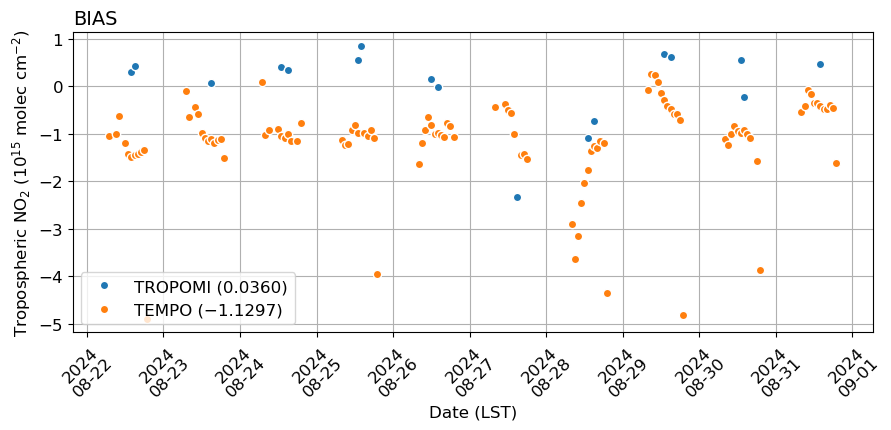

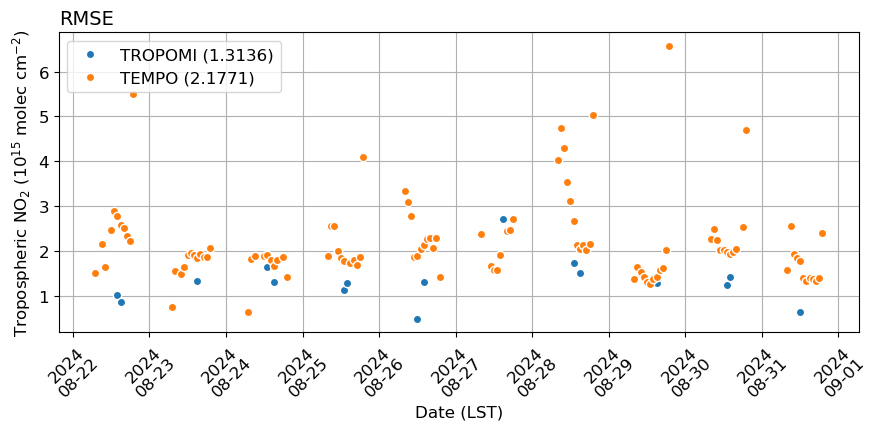

In [10]:
for stattype in ["bias", "rmse"]:
    fig, ax = plt.subplots()
    set_size(axe_w, axe_h, b=0.25, l=0.1, r=0.95, t=0.9)
    # ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    shortobsname_list = []
    for obs in all_df["obsname"].unique():
        subset = all_df[all_df["obsname"] == obs]
        mean = subset[stattype].mean()
        if mean < 0:
            mean_str = f"{minussign}{abs(mean):.4f}"
        else:
            mean_str = f"{mean:.4f}"
        shortobsname_list.append(obsname_dict[obs])
        label = f"{obsname_dict[obs]} ({mean_str})"
        ax.plot(
            subset["localtime"],
            subset[stattype],
            marker="o",
            linestyle=" ",
            label=label,
            mec="w",
        )

    filename_obstag = "_".join(shortobsname_list)
    date_format = mdates.DateFormatter("%Y\n%m-%d")  # Customize this
    plt.gca().xaxis.set_major_formatter(date_format)
    plt.xticks(rotation=45)
    plt.title(stattype.upper(), loc="left", fontsize=txsize + 2)
    plt.xlabel("Date (LST)")
    plt.ylabel(ylbstr)
    plt.grid(True)
    plt.legend(fontsize=txsize)
    outname = f"{plts_path}/{stattype}.{filename_obstag}.{sdate}_{edate}.png"
    print(outname)
    fig.savefig(outname, dpi=plot_quality)